In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']#修改默认字体

* 分布
    * distplot 概率分布图
    * kdeplot 概率密度图
    * jointplot 联合密度图
    * pairplot 多变量图
* 分类
    * boxplots 箱线图
    * violinplots 提琴图
    * barplot 柱形图
    * factorplot 因子图
* 线性
    * lmplot 回归图
    * heatmap

In [3]:
columns = ['user_id','order_dt','order_product','order_amount']
df = pd.read_table('f:/test/CDNOW_master.txt',names=columns,sep='\s+')

In [4]:
df.head()

,user_id,order_dt,order_product,order_amount
0,1,19970101,1,11.77
1,2,19970112,1,12.00
2,2,19970112,5,77.00
3,3,19970102,2,20.76
4,3,19970330,2,20.76


In [5]:
df.shape

(69659, 4)

## 分布
    * distplot 概率分布图
    * kdeplot 概率密度图
    * jointplot 联合密度图
    * pairplot 多变量图

* 概率分布图

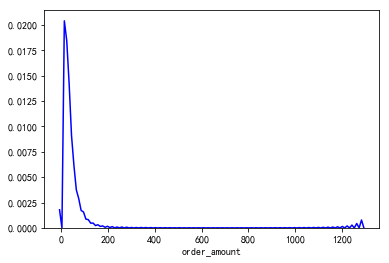

In [6]:
sns.distplot(df.order_amount,kde=True,hist=False,color='b')

* 概率密度图

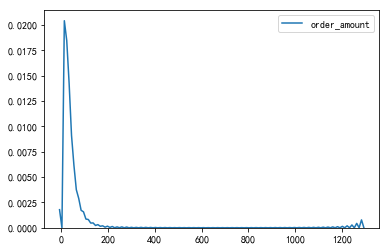

In [7]:
sns.kdeplot(df.order_amount)

* 方法一

In [8]:
grouped = df.pivot_table(index='user_id',values=['order_dt','order_product','order_amount'],aggfunc='sum')

In [9]:
grouped.head()

,order_amount,order_dt,order_product
user_id,,,
1,11.77,19970101,1
2,89.00,39940224,6
3,156.46,119833602,16
4,100.50,79882233,7
5,385.61,219686137,29


* 方法二

In [10]:
grouped_user = df.groupby('user_id').sum()

In [11]:
grouped_user.head()

,order_dt,order_product,order_amount
user_id,,,
1,19970101,1,11.77
2,39940224,6,89.00
3,119833602,16,156.46
4,79882233,7,100.50
5,219686137,29,385.61


## 联合密度图 jointplot

d:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
d:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


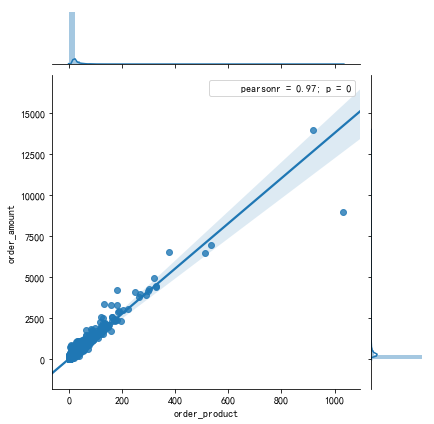

In [12]:
sns.jointplot(grouped.order_product,grouped.order_amount,kind='reg') # kind='reg' 线性回归

In [13]:
df.order_dt=pd.to_datetime(df.order_dt)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
user_id          69659 non-null int64
order_dt         69659 non-null datetime64[ns]
order_product    69659 non-null int64
order_amount     69659 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


# 构建RFM模型
* R：最近一次消费
* F: 消费频率
* M: 消费金额

In [14]:
rfm = df.pivot_table(index = 'user_id',
              values = ['order_product','order_amount','order_dt'],
              aggfunc = {'order_dt':'max', #最近购买
                         'order_product':'sum',# 购买总量
                        'order_amount':'sum'})# 消费总金额

In [15]:
rfm.head()

,order_amount,order_dt,order_product
user_id,,,
1,11.77,1970-01-01 00:00:00.019970101,1
2,89.00,1970-01-01 00:00:00.019970112,6
3,156.46,1970-01-01 00:00:00.019980528,16
4,100.50,1970-01-01 00:00:00.019971212,7
5,385.61,1970-01-01 00:00:00.019980103,29


In [16]:
rfm['R'] = -(rfm.order_dt - np.datetime64('today'))/np.timedelta64(1,'D')

* /np.timedelta64(1,'D') , 消除单位days
* np.datatime('today')

In [17]:
rfm.rename(columns={'order_product':'F','order_amount':'M'},inplace=True)

In [18]:
rfm.head()

,M,order_dt,F,R
user_id,,,,
1,11.77,1970-01-01 00:00:00.019970101,1,17841.0
2,89.00,1970-01-01 00:00:00.019970112,6,17841.0
3,156.46,1970-01-01 00:00:00.019980528,16,17841.0
4,100.50,1970-01-01 00:00:00.019971212,7,17841.0
5,385.61,1970-01-01 00:00:00.019980103,29,17841.0


## 用户分级

In [19]:
def rfm_func(x):
    level = x.apply(lambda x:'1' if x>=0 else '0')
    label = level.R + level.F + level.M
    d = {
        '111':'重要价值客户',
        '011':'重要保持客户',
        '101':'重要发展客户',
        '001':'重要挽留客户',
        '110':'一般价值客户',
        '010':'一般保持客户',
        '100':'一般发展客户',
        '000':'一般挽留客户'
        }
    result = d[label]
    return result

In [20]:
rfm['label'] = rfm[['R','F','M']].apply(lambda x:x-x.mean()).apply(rfm_func,axis=1)

In [21]:
rfm.head()

,M,order_dt,F,R,label
user_id,,,,,
1,11.77,1970-01-01 00:00:00.019970101,1,17841.0,一般发展客户
2,89.00,1970-01-01 00:00:00.019970112,6,17841.0,一般发展客户
3,156.46,1970-01-01 00:00:00.019980528,16,17841.0,重要价值客户
4,100.50,1970-01-01 00:00:00.019971212,7,17841.0,一般发展客户
5,385.61,1970-01-01 00:00:00.019980103,29,17841.0,重要价值客户


## 可视化

* jointplot 联合密度图

d:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
d:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


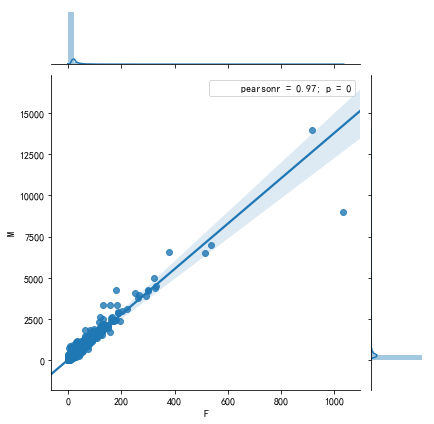

In [22]:
sns.jointplot(rfm.F,rfm.M,kind='reg')

# pandas绘图
## 散点图矩阵
* pd.plotting.scatter_matrix
* diagonal=''
    * kde
    * hist

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0929FEF0>,
      dtype=object)

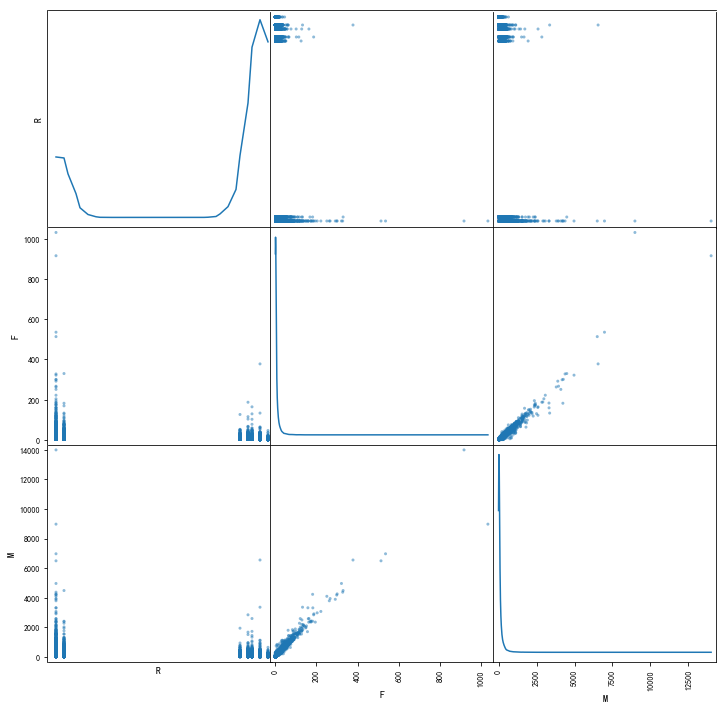

In [23]:
pd.plotting.scatter_matrix(rfm[['R','F','M']],diagonal='kde',figsize=(12,12))

## pairplot 多变量图

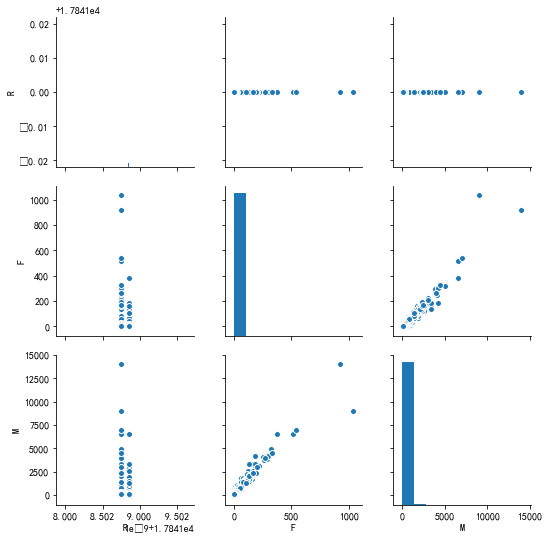

In [24]:
sns.pairplot(rfm[['R','F','M']])

# 分类
    * boxplots 箱线图
    * violinplots 提琴图
    * barplot 柱形图
    * factorplot 因子图

In [25]:
city = pd.read_csv('f:/test/canyin.csv',encoding='gbk')

In [26]:
city.shape

(5863, 8)

In [27]:
city.head()

,城市,类型,店名,点评,人均,口味,环境,服务
0,北京,私房菜,梧桐宇私房菜,45.0,80.0,7.3,7.3,7.1
1,北京,私房菜,小东北私房菜,1.0,35.0,6.9,6.9,6.9
2,北京,私房菜,辣家私房菜,1.0,NaN,6.9,6.9,6.9
3,北京,私房菜,鸿福天原,NaN,NaN,NaN,NaN,NaN
4,北京,私房菜,虾而美(北京)餐饮管理有限公司,NaN,NaN,NaN,NaN,NaN


## 箱线图 boxplots
* hue 设置对比label

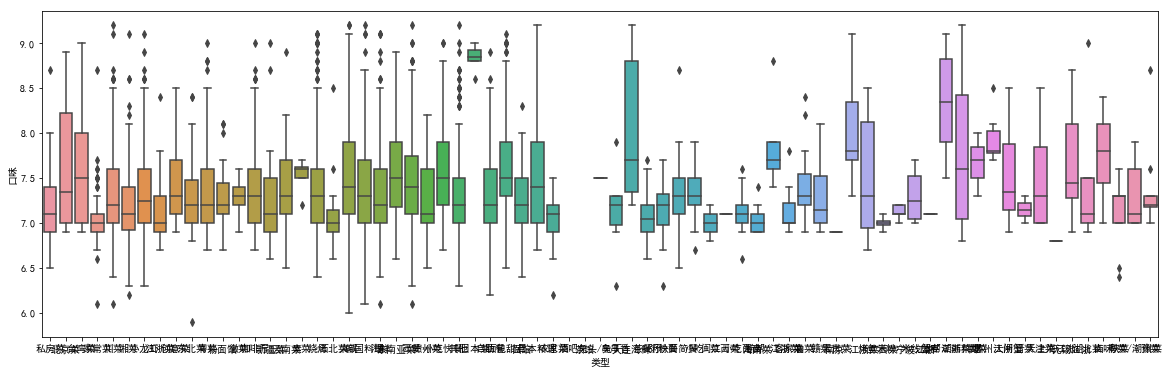

In [28]:
plt.figure(figsize=(20,6))
sns.boxplot(x='类型',y='口味',data=city)

In [29]:
city1 = city.query("(城市 == '上海')|(城市 == '北京')")

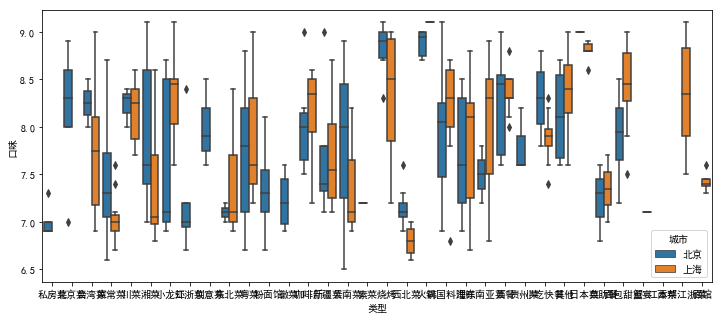

In [30]:
plt.figure(figsize=(12,5))
sns.boxplot(x='类型',y='口味',data=city1,hue='城市')

## violinplots 提琴图
* hue 分类
* split=True 拼接

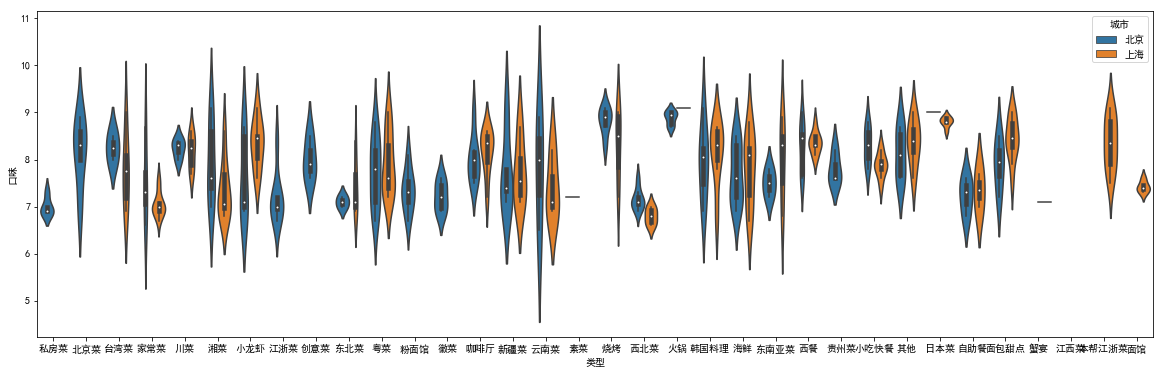

In [31]:
plt.figure(figsize=(20,6))
sns.violinplot(x='类型',y='口味',data=city1,hue='城市')

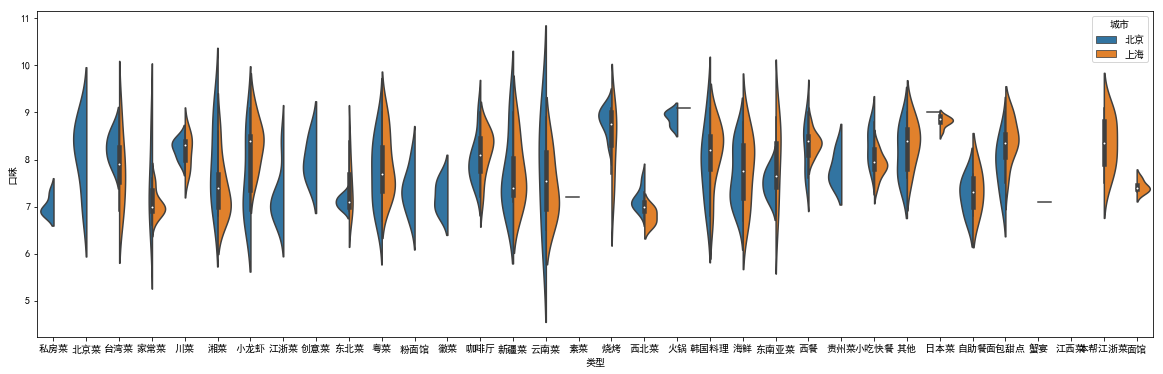

In [32]:
plt.figure(figsize=(20,6))
sns.violinplot(x='类型',y='口味',data=city1,hue='城市',split=True)

## barplot 柱形图

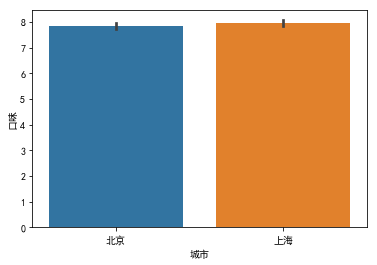

In [33]:
sns.barplot(x='城市',y='口味',data=city1)

## factorplot 因子图
* size 画布大小
* kind=
    * 'box'
    * 'point'
    * 'violin'
* aspect= 调整画布高度
* col='' 拆分子图方式
* col_wrap=3 每行几个图

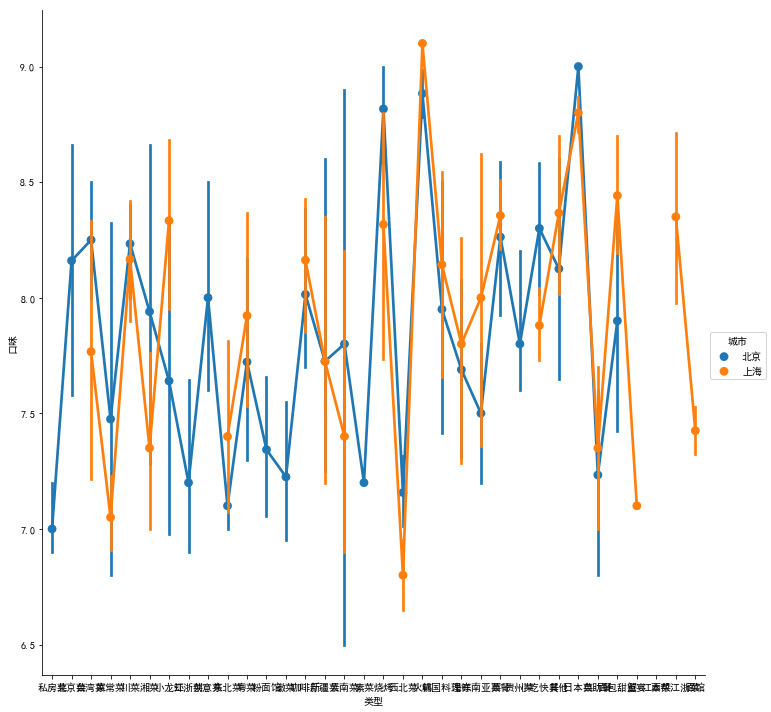

In [34]:
sns.factorplot(x='类型',y='口味',hue='城市',data=city1,size=10)

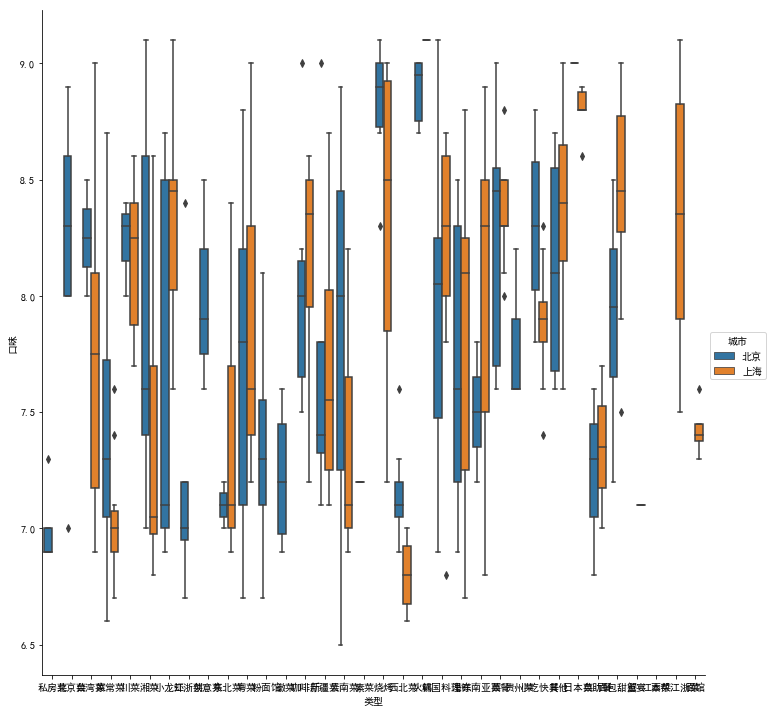

In [35]:
sns.factorplot(x='类型',y='口味',hue='城市',data=city1,size=10,kind='box')

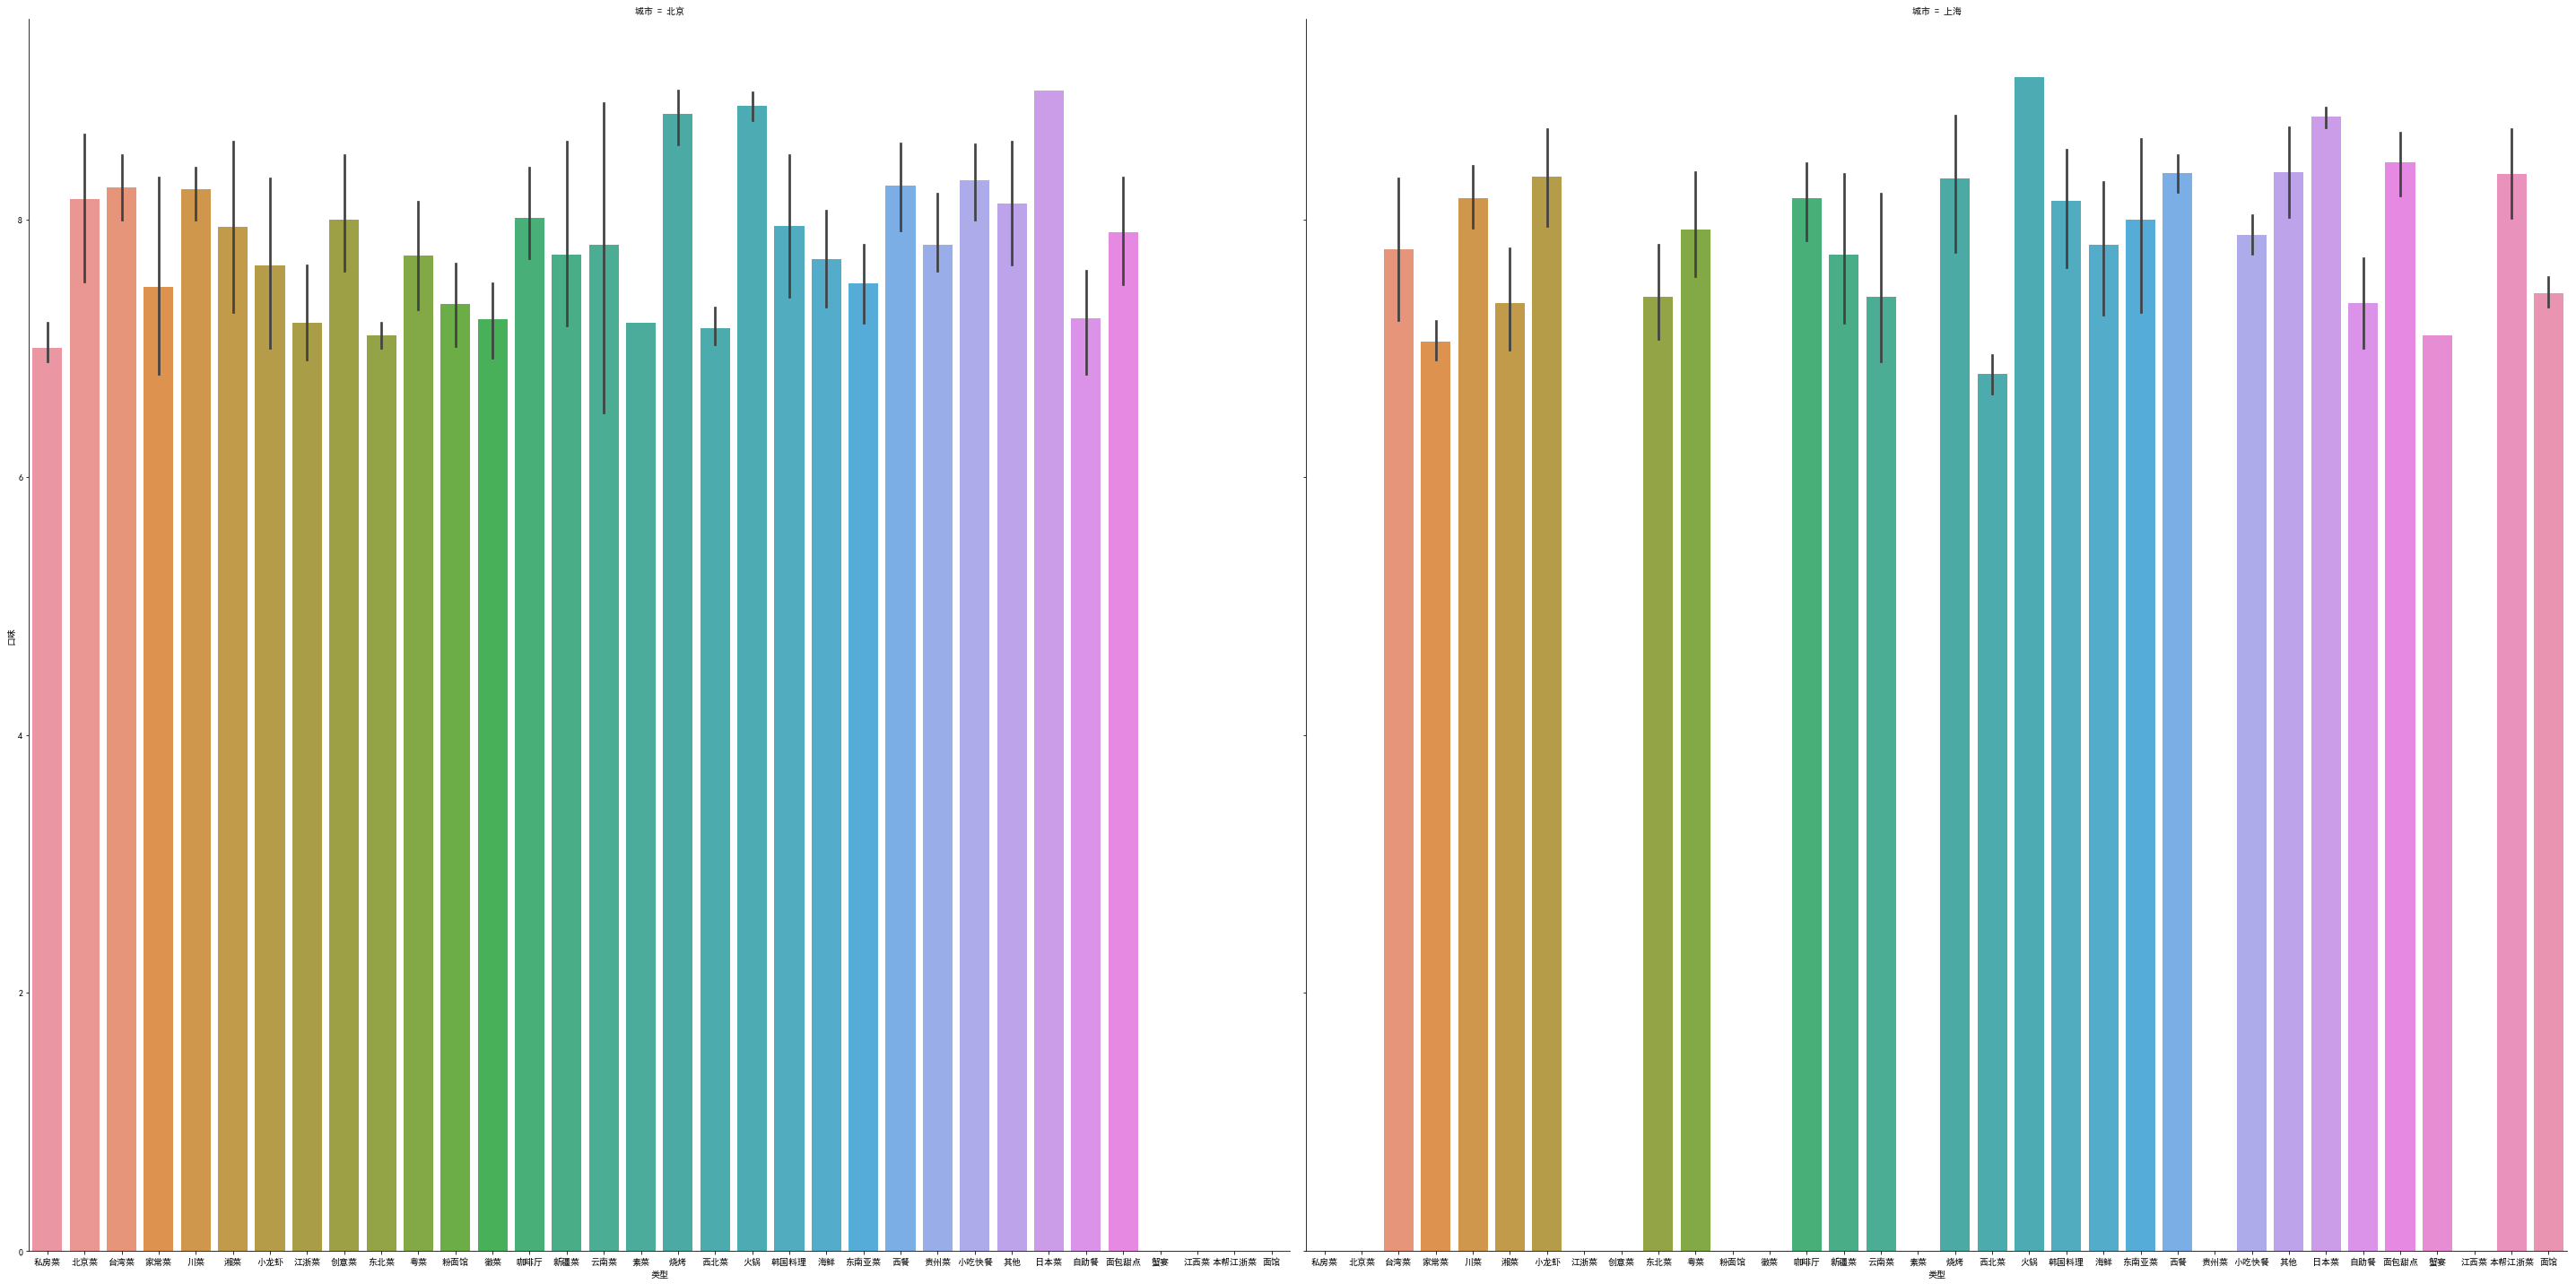

In [36]:
sns.factorplot(x='类型',y='口味',col='城市',data=city1,size=20,kind='bar')

# 线性
    * lmplot 回归图
        * hue 分类方式，按列
        * order=1 线性方程
        * order=2 非线性方程
        * size
        * col
        * col_wrap=4，每行4个图，封装
    * heatmap

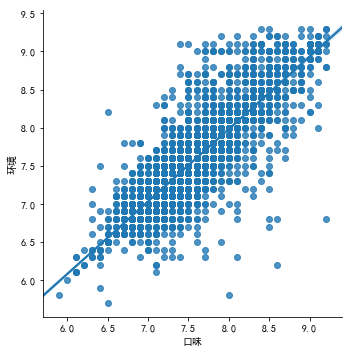

In [37]:
sns.lmplot(x='口味',y='环境',data=city)

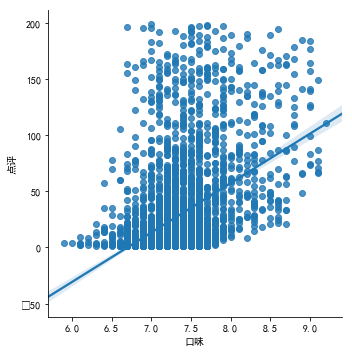

In [38]:
sns.lmplot(x='口味',y='点评',data=city.query("点评<200"))

* 口味和点评数之间不相关

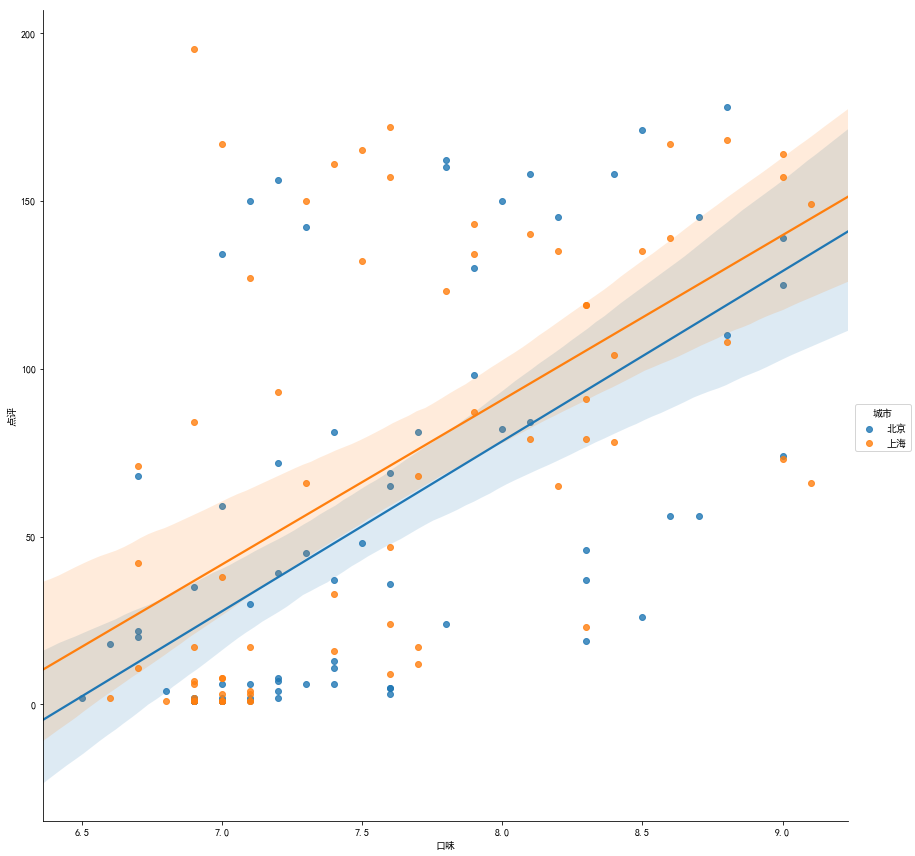

In [39]:
sns.lmplot(x='口味',y='点评',data=city1.query("点评<200"),hue='城市',size=12)

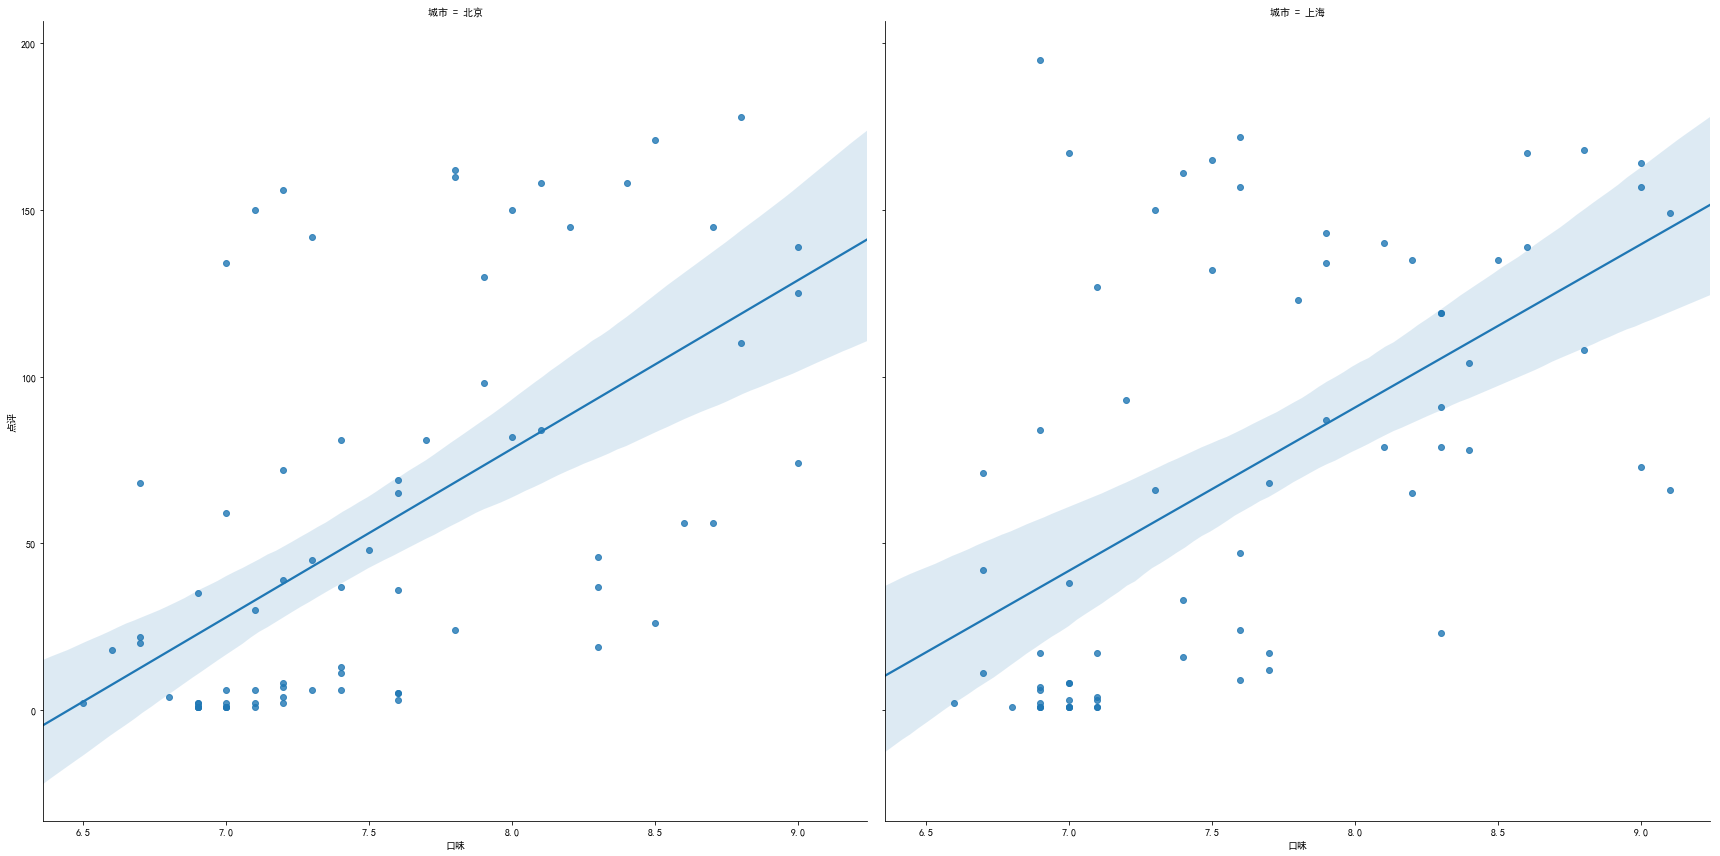

In [40]:
sns.lmplot(x='口味',y='点评',data=city1.query("点评<200"),col='城市',size=12)

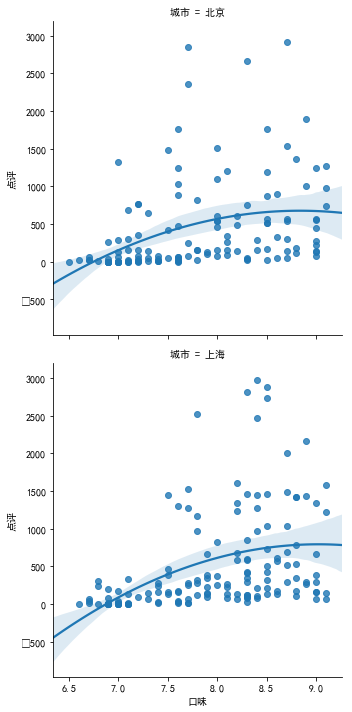

In [41]:
sns.lmplot(x='口味',y='点评',data=city1.query('点评<3000'),row='城市',order=2)

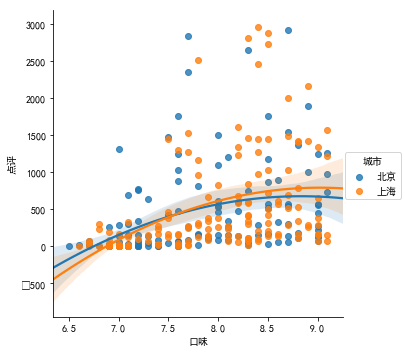

In [42]:
sns.lmplot(x='口味',y='点评',data=city1.query('点评<3000'),hue='城市',order=2)

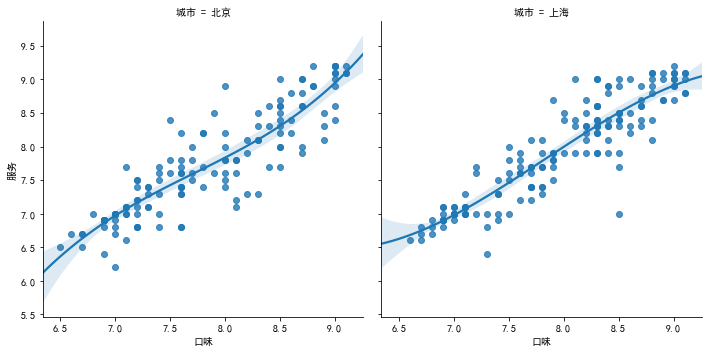

In [43]:
sns.lmplot(x='口味',y='服务',data=city1,col='城市',order=3)

## 热力图
* sns.heatmap
* annot =True显示数值

In [44]:
city.head()

,城市,类型,店名,点评,人均,口味,环境,服务
0,北京,私房菜,梧桐宇私房菜,45.0,80.0,7.3,7.3,7.1
1,北京,私房菜,小东北私房菜,1.0,35.0,6.9,6.9,6.9
2,北京,私房菜,辣家私房菜,1.0,NaN,6.9,6.9,6.9
3,北京,私房菜,鸿福天原,NaN,NaN,NaN,NaN,NaN
4,北京,私房菜,虾而美(北京)餐饮管理有限公司,NaN,NaN,NaN,NaN,NaN


In [45]:
hm = city.pivot_table(index='城市',columns='类型',values='口味',aggfunc='mean')

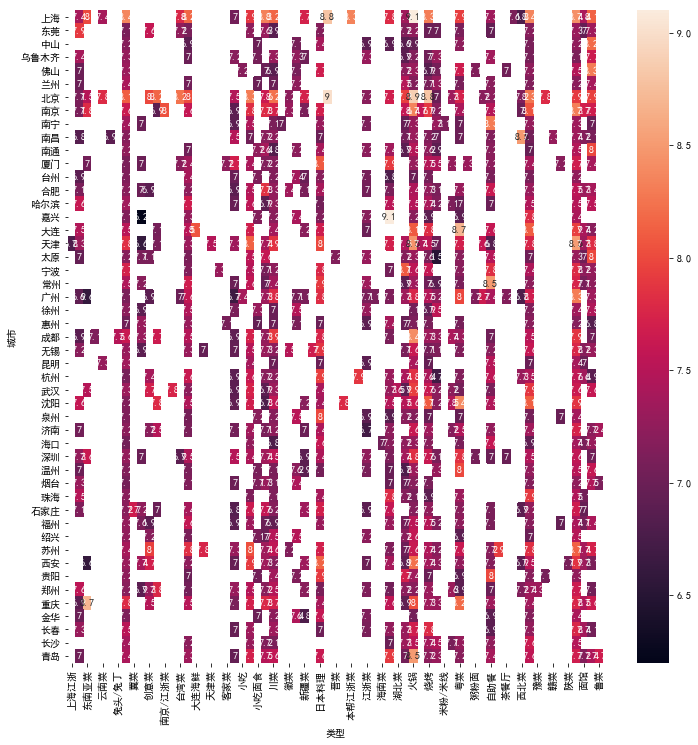

In [46]:
plt.figure(figsize=(12,12))
sns.heatmap(hm,annot=True)